# Hackathon Dotz

### Importando Bibliotecas

In [147]:
!pip install keras-bert
!pip install keras-rectified-adam

!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [148]:
import codecs
import tensorflow as tf
from tqdm import tqdm
from chardet import detect

from google.colab import files
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('punkt')
import collections
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#from tensorflow.keras import layers
#from tensorflow import keras
import keras
from keras_radam import RAdam
from keras import backend as K
from keras_bert import load_trained_model_from_checkpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action = 'ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Importando Arquivos

In [149]:
#Carregar os dados para o google colab
uploaded = files.upload()

Saving Dados Gerais Datasets.txt to Dados Gerais Datasets.txt


In [0]:
# Importação dos dataset
df = pd.read_csv('Hackathon_Base_Treino_comdep.csv')
df2 = pd.read_csv('Hackathon_Base_Teste.csv')

In [151]:
df.head(5)

,DESCRIÇÃO PARCEIRO,SUB-CATEGORIA,CATEGORIA,DEPARTAMENTO
0,"PASTA INT VITAPOWER 1,005KG AMEND/SHOT",TRADICIONAL,CREME DE AMENDOIM,MERCEARIA DOCE
1,ESPONJA BETTANIN BRILHUS C/1,MULTIUSO,ESPONJA SINTÉTICA,CUIDADOS COM A COZINHA
2,AGUA MIN SCHIN S/GAS 500ML,SEM GÁS,ÁGUA MINERAL,BEBIDAS NÃO ALCOÓLICAS
3,FITA DUPLA FACE C/SUPORTE SCOTCH,FITA ADESIVA,PAPELARIA,PAPELARIA
4,MASSA PIZZA ROMANHA OREGANO PCT 160G,PIZZA REGULAR,MASSA FRESCA,MASSAS FRESCAS


In [0]:
#df = df.query('DEPARTAMENTO in ["MERCEARIA DOCE","PAPELARIA","MASSAS FRESCAS","CUIDADOS COM A COZINHA"]')

In [153]:
# Verificando os tamanhos das classificações
classifica = df[['DEPARTAMENTO']]
qtd_dep = int(classifica.nunique().values)
classifica = df[['CATEGORIA']]
qtd_cat = int(classifica.nunique().values)
classifica = df[['SUB-CATEGORIA']]
qtd_sub = int(classifica.nunique().values)

# Conferindo valores
print('Existem', qtd_dep, 'DEPARTAMENTOS')
print('Existem', qtd_cat, 'CATEGORIA')
print('Existem', qtd_sub, 'SUB-CATEGORIA')

# Variáveis de preparação dos dados
# Variáveis importantes
pontuacao = ['.',',','-','+',':',';','&','+','/','!','#','%','(',')','  ']
# Palavras para retirar da análise
stop_words = ['em','sao','ao','de','da','do','para','c','kg','un','ml','pct','und','das','no','ou', 
              'com','sem','gfa','jg','la','1','2','3','4','5','6','7','8','9','0','a','b','c','d','e',
              'f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','x','w','y','z']
stop_words_sub = ['em','sao','ao','de','da','do','para','c','kg','un','ml','pct','und','das',
                  'no','ou','gfa','jg','la','1','2','3','4','5','6','7','8','9','0']

# Variável tamando da base de teste
test_size = 0.5


Existem 53 DEPARTAMENTOS
Existem 332 CATEGORIA
Existem 1968 SUB-CATEGORIA


### Preparando Dados

In [0]:
# Excluindo da descrição texto após os números, informações julgadas irrelevantes para a classificação.
df['DESC_AJUSTADA'] = df['DESCRIÇÃO PARCEIRO'].str.lower().str.replace('[0-9]+', '', regex=True)
df2['DESC_AJUSTADA'] = df2['DESCRIÇÃO PARCEIRO'].str.lower().str.replace('[0-9]+', '', regex=True)

# Excluindo da descrição puntuação, informações julgadas irrelevantes para a classificação.
for x in pontuacao:
  df['DESC_AJUSTADA'] = df['DESC_AJUSTADA'].str.replace(x, ' ')
  df2['DESC_AJUSTADA'] = df2['DESC_AJUSTADA'].str.replace(x, ' ')

# Função para retirar stop words
def tokenize_df(tokenized_words):
  tokenized_words = word_tokenize(tokenized_words)
  stop = [word for word in tokenized_words if word not in stop_words]
  new_text = TreebankWordDetokenizer().detokenize(stop)
  return new_text

# Eliminando as stop words
df['DESC_AJUSTADA'] = df['DESC_AJUSTADA'].apply(tokenize_df)
df2['DESC_AJUSTADA'] = df2['DESC_AJUSTADA'].apply(tokenize_df)

### Etapa 1 - DEPARTAMENTO

In [155]:
# Selecionando as unicas palavras da DESCRIÇÃO PARCEIRO
texto = df[['DESC_AJUSTADA']]
texto['TOKENIZED'] = texto['DESC_AJUSTADA'].apply(word_tokenize)
texto = list(texto.TOKENIZED)
lista = [item for sublista in texto for item in sublista]
lista = sorted(lista)
unicas = set(lista)
print('Quantidade de observações:', len(texto), '\n')
print('Quantidade de GERAL palavras:', len(lista), '\n')
print('Quantidade de UNICA palavras:', len(unicas), '\n')
counter = collections.Counter(lista)

Quantidade de observações: 22009 

Quantidade de GERAL palavras: 101837 

Quantidade de UNICA palavras: 13599 



In [0]:
#departamentos = list(set(list(df['DEPARTAMENTO'])))
#encoder_dep = tfds.features.text.SubwordTextEncoder(vocab_list=departamentos)
#print('Vocabulary size(DEPARTAMENTO): {}'.format(encoder_dep.vocab_size))

In [0]:
# Gerar um arquivo com a lista de palavras unicas
#arquivo = open('dotz.txt', 'w')
#arquivo.write(str(counter))
#arquivo.close()

In [158]:
# Gerando encoder com o vocabulário das palavras
encoder = tfds.features.text.SubwordTextEncoder(vocab_list=unicas)
print('Vocabulary size(DESCRIÇÃO PARCEIRO): {}'.format(encoder.vocab_size))

Vocabulary size(DESCRIÇÃO PARCEIRO): 13856


In [159]:
# Exemplo do encode e decode da DESCRIÇÃO PARCEIRO	
sample_string = 'pasta int vitapower amend shot'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [276, 13632, 6858, 13632, 3990, 13632, 4091, 13632, 5648]
The original string: "pasta int vitapower amend shot"


In [0]:
# Validando a string original com a string após o decode
assert original_string == sample_string

In [161]:
# Exemplificando a relação de index ----> word
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

# Encode departamado
dep = df.DEPARTAMENTO
dep_encode = LabelEncoder()
dep_encode.fit_transform(dep)

276 ----> pasta
13632 ---->  
6858 ----> int
13632 ---->  
3990 ----> vitapower
13632 ---->  
4091 ----> amend
13632 ---->  
5648 ----> shot


array([39, 11,  3, ..., 15, 39, 28])

In [162]:
# Definindo feature e target
x = list(df['DESC_AJUSTADA'])
y = list(dep_encode.fit_transform(dep))
class_names = list(set(list(df['DEPARTAMENTO'])))

# Dividindo dataset em treino e teste
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

print('classes: %s' % (class_names))

classes: ['CUIDADOS COM O CABELO', 'BEBIDAS NÃO ALCOÓLICAS', 'ELETRO', 'PRATOS PRONTOS', 'PEIXARIA', 'INFANTIL', 'HIGIENE ORAL', 'CUIDADOS COM MÃOS E PÉS', 'CUIDADOS COM O BANHEIRO', 'LEITE', 'CUIDADOS COM A CASA', 'JARDINAGEM', 'SALGADO', 'FRIOS', 'HORTIFRUTI', 'CUIDADOS COM O CORPO', 'TEXTIL', 'DECORAÇÃO', 'CONGELADOS SALGADOS', 'CAMA, MESA E BANHO', 'BEBIDAS ALCOÓLICAS', 'GORDUROSOS', 'RESFRIADOS', 'HIGIENE PESSOAL', 'CUIDADOS COM A BARBA', 'SALGADOS', 'EMBUTIDOS', 'TABACO', 'PADARIA', 'DESCARTÁVEIS', 'HIGIENE PESSOAL INFANTIL', 'UTILIDADES DE COZINHA', 'LAVANDERIA', 'CUIDADOS COM A ROUPA', 'AÇOUGUE', 'PET SHOP', 'CUIDADOS COM O ROSTO', 'CONGELADOS DOCES', 'IOGURTES', 'MERCEARIA DOCE', 'BRINQUEDO', 'UTILIDADES DE BANHEIRO', 'MERCEARIA SALGADA', 'MASSAS FRESCAS', 'CUIDADOS COM OS OLHOS', 'MALAS/NECESSAIRES', 'EMPÓRIO', 'MANUTENÇÃO', 'CALÇADO', 'CUIDADOS COM A COZINHA', 'LAZER/CAMPING', 'PAPELARIA', 'AUTOMOTIVO']


In [0]:
SEQ_LEN = 128
BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-4

In [0]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = pretrained_path + '/bert_config.json'
checkpoint_path = pretrained_path + '/bert_model.ckpt'
vocab_path = pretrained_path + '/vocab.txt'

In [0]:
model = load_trained_model_from_checkpoint(
      config_path,
      checkpoint_path,
      training=True,
      trainable=True,
      seq_len=SEQ_LEN,
  )

In [0]:
#model.summary()

In [0]:
import codecs
from keras_bert import Tokenizer
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
        
# print(token_dict)

In [0]:
tokenizer = Tokenizer(token_dict)

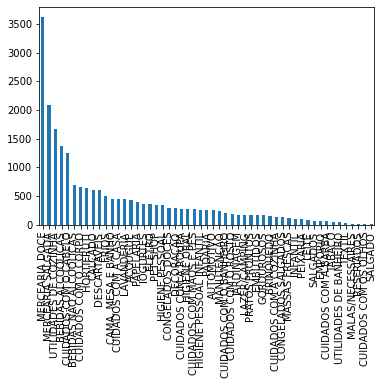

In [169]:
df['DEPARTAMENTO'].value_counts().plot(kind = 'bar');

In [0]:
# Criação da matriz
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

# Encode do input
def encode_input(x):
  lista_x = []
  for desc in x:
    desc_encode = encoder.encode(desc)
    desc_encode = pad_to_size(desc_encode, 128)
    lista_x.append(desc_encode)

  return lista_x

lista_x = encode_input(x)
x_train = [lista_x[:20000], np.zeros_like(lista_x[:20000])]
x_test = [lista_x[20001:], np.zeros_like(lista_x[20001:])]
y_train = np.array(y[:20000])
y_test =  np.array(y[20001:])

In [0]:
inputs = model.inputs[:2]
dense = model.get_layer('NSP-Dense').output
outputs = keras.layers.Dense(units=qtd_dep, activation="softmax")(dense)

model = keras.models.Model(inputs, outputs)
model.compile(
  RAdam(learning_rate =LR),
  loss='sparse_categorical_crossentropy',
  metrics=['sparse_categorical_accuracy'],
)

In [0]:
#model.summary()

In [192]:
model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
   # batch_size=128,
)

Epoch 1/20
   32/20000 [..............................] - ETA: 1:38:30 - loss: 4.4269 - sparse_categorical_accuracy: 0.0000e+00

ResourceExhaustedError: ignored